# Unsupervised Learning on the Dry Bean Dataset

In this lab we will try to obtain valuable information using Unsupervised Learning techniques.

The original data has been downloaded from https://archive-beta.ics.uci.edu/dataset/602/dry+bean+dataset (Dry Bean Dataset. (2020). UCI Machine Learning Repository)

**Data Set Description**:

Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. 
A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.

## Loading and Pre-treatment of the Data

In [1]:
# Load libraries and modules
import pandas as pd
from sklearn import preprocessing
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.metrics.cluster import normalized_mutual_info_score
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
FFILE = './Dry_Bean_Dataset.xlsx'
if os.path.isfile(FFILE): 
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/Lab5/Dry_Bean_Dataset.xlsx"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/Lab5/Dry_Bean_Dataset.xlsx"

File already exists
File is readable


In [3]:
# Load the data
data = pd.read_excel('./Dry_Bean_Dataset.xlsx')
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [4]:
# Transform the data to use it as numpy arrays. 
X = data.iloc[:,:-1].values
label = data.iloc[:,16].values
print(X.shape)
N = X.shape[0]  # Number of data points
nc = X.shape[1]  # Number of features/components
print(np.unique(label)) 

(13611, 16)
['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']


In [5]:
# Ordinal encoder for the ground truth labels
enc = preprocessing.OrdinalEncoder()
enc.fit(label.reshape(-1, 1))
y = enc.transform(label.reshape(-1, 1))
print(y)  # Encoded labels

[[5.]
 [5.]
 [5.]
 ...
 [3.]
 [3.]
 [3.]]


In [6]:
# Rescale the features of the data since the units are different: substract the average and divide by the standard deviation
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Principal Component Analysis (PCA)

**Objective**: find the set of orthogonal directions along which the variance of the data is the highest.

Summary of the method:

* Center the data feature matrix $X$;

* Compute the covariance matrix $C$ of the data as $C=X^T X$;

* Compute eigenvalues and eigenvectors of the covariance matrix $C$ (use function `eigh` of `scipy.LA`), and sort them according to the decreasing order of the eigenvalues. Arrange them as coumn of a matrix $A$.

**Recall**: eigenvalues are the variance of the data along the direction of the corresponding eigenvector. 

* Compute principal components as $X\cdot A$

In [7]:
# Since the features are already centered, we can compute the covariance matrix as:
# C=X^t X
Cov = np.matmul(X_scaled.transpose(), X_scaled)
lamb, v = LA.eigh(Cov)  # eigenvector and eigenvalues of the covariance matrix
idx = np.argsort(-lamb)
lambs = lamb[idx]
vs = v[:,idx]
print(lambs)
projection = np.matmul(X_scaled, vs)

[1.20792591e+05 5.75603161e+04 1.74363753e+04 1.11372395e+04
 5.96552251e+03 2.50390339e+03 1.51931587e+03 7.07951663e+02
 1.12430424e+02 1.97888961e+01 1.43485622e+01 4.00140097e+00
 2.02524369e+00 1.36249763e-01 2.92107490e-02 2.42928028e-02]


### Model Assessment: choose the number of PCs to keep

**Objective**: choose the final dimension $d$ of the transformed data.

1. Proportion of variance explained: given eigenvalues $\lambda_i$ of the covariance matrix and a threshold $t\in [0, 1]$, choose $d$ s.t. the ratio $\chi_d = \frac{\sum_{i=1}^d \lambda_i}{\sum_{i=1}^D \lambda_i} > t$ 

2. Check the existence of a gap in the spectrum of the covariance matrix.

In [8]:
# prportion of variance explained
cumul = np.zeros(nc)
total = np.sum(lambs) # traccia 
for i in range(nc):
    cumul[i] = np.sum(lambs[:i+1])/total
comp = np.arange(nc) + 1

In [9]:
# PCA with sklearn 
pca = PCA()
pca.fit(X_scaled)
projection = pca.transform(X_scaled)
cumul = np.zeros(nc)
for i in range(nc):
    cumul[i] = np.sum(pca.explained_variance_ratio_[:i+1])

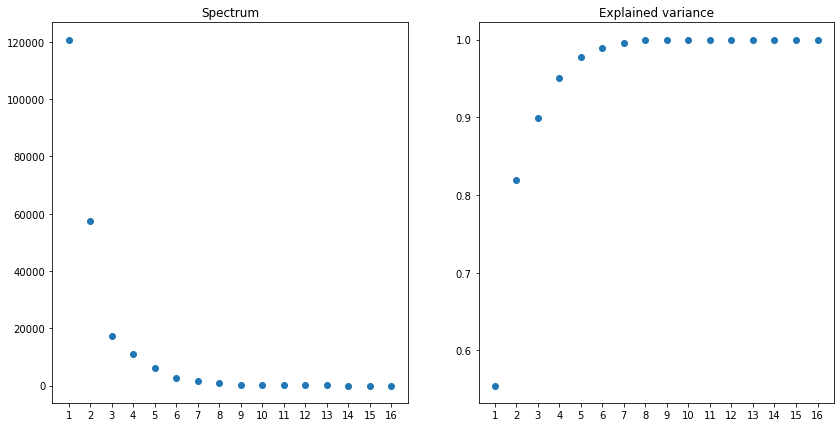

In [10]:
f, [ax1, ax2] = plt.subplots(1, 2,figsize = (14, 7))
ax1.set_title('Spectrum')
ax1.scatter(comp, lambs)
ax1.set_xticks(comp)
ax2.set_title('Explained variance')
ax2.scatter(comp, cumul)
ax2.set_xticks(comp)
plt.show()

In [11]:
# Number of components depending on the explained variance threshold.
for t in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    nc = np.argmax(cumul - t > 0.) + 1
    print(t, nc)

0.8 2
0.85 3
0.9 4
0.95 4
0.97 5
0.99 7
0.999 8


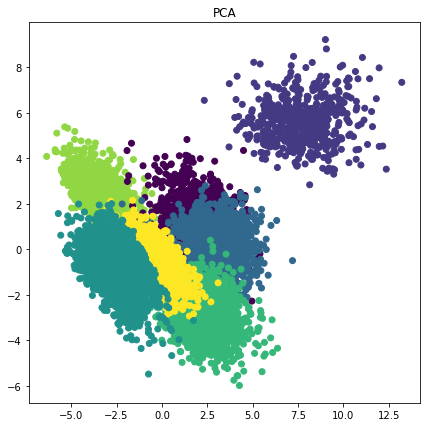

In [12]:
# plotting the data set in 2D (i.e. keep only 2 PCs) colored by its ground truth label
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(projection[:,0],projection[:,1], c=y)
ax.set_title('PCA')
plt.show()

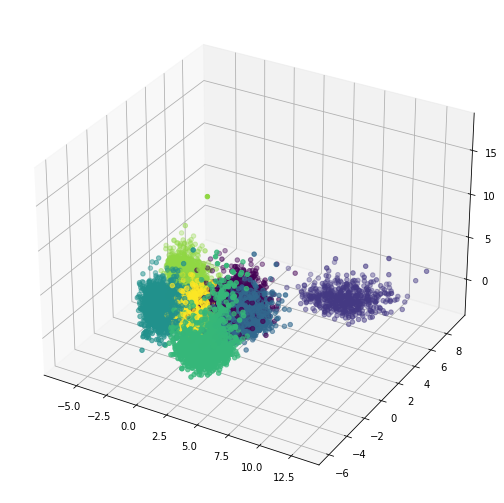

In [13]:
# Now in 3D (i.e. keep only 3 PCs)
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0],projection[:,1], projection[:,2],c=y)
plt.show()

1. What would happen if we don't rescale the features?

2. Which is the Intrinsic Dimension (ID) of the data set?

  **Recall**: the ID of a dataset is the minimum number of dimensions we need to describe the data in a accurate way.

3. Could you compute the two-NN estimate of the ID?

  The procedure works as follows:

  1. Compute pairwise distances among points;
  2. For each point $i$, extract the distance from its two closest neighbors $r_{i1}, r_{i2}$ respectively;
  3. Compute the ratio $\mu_i = \frac{r_{i2}}{r_i1}$;
  4. Compute the empirical cumulative distribution $\mathcal{F}(\mu)$ of $\mu$;
  5. Find the best fitting line for the dataset $\{\log \mu_i, \log (1 - \mathcal{F}(\mu_i)\}_{i=1}^N$
  6. The intrinsic dimension is given by the slope of this fitted line.

In [14]:
# compute matrix distance
X_scaled_u = np.unique(X_scaled, axis=0)
dist = cdist(X_scaled_u, X_scaled_u)
dist.sort(axis=1)
mu_i = np.divide(dist[:, 2], dist[:, 1])
log_mu_i = np.log(mu_i)
two_nn = 1 / np.mean(log_mu_i)
print(two_nn)

5.707929194326163


## K-means

Flat clustering algorithms whose goal is to minimize the intracluster distance while maximizing the intercluster distance. 

We will compute the k-means clustering using two types of initialization:
    
  1. Random initialization: cluster centroids are initialized picking random points from the dataset;
  
  2. k-means++: choose first cluster center at random, then choose new cluster centers in such a way that they are far from existing centers.

In [15]:
def k_means_internal(k, X, init):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset 
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    '''
    # get dataset size
    N = X.shape[0] # number of points 
    nc = X.shape[1] # number of coordinates/dimensions
    # clusters
    ll = np.arange(k) 
    z = np.zeros(N, dtype='int') # cluster number assigned to each data point
    cent = np.zeros([k, nc]) # coordinates of the cluster centers, array di tuple
    # k-means++
    if (init=='++'):
        b = np.random.choice(N, 1, replace=False) # choose the first cluster center at random
        cent[0, :] = X[b, :] 
        nchosen = 1 # number of cluster centers already set
        while (nchosen < k):
            dist = cdist(cent[:nchosen, :], X) # distance of each point from the cluster centers
            dmin = np.min(dist, axis=0) # min distance btw point and cluster centers
            prob = dmin**2 
            prob = prob/np.sum(prob) 
            # choose next center according to the computed prob
            b = np.random.choice(N, 1, replace=False, p=prob) 
            cent[nchosen, :] = X[b,:]
            nchosen = nchosen + 1
    # random initialization
    else:
        b = np.random.choice(N, k, replace=False)  # choose the k centers randomly 
        for i in ll:
            cent[i, :] = X[b[i],:]
    dist = cdist(cent, X)  # distance of each point from cluster centers 
    z_new = np.argmin(dist, axis=0) # assign each point to cluster with closest center
    dmin = np.min(dist,axis=0)
    niter = 0
    L = np.sum((dmin)**2) # loss function evaluation
    while (z_new != z).any(): # until a stable configuration is reached
        z = np.copy(z_new)
        for i in range(k):
            cent[i, :] = np.average(X[z==i,:],axis=0) # compute cluster centroids
        dist = cdist(cent, X) # update distances from cluster centers
        z_new = np.argmin(dist, axis=0) # find cluster with min centroid distance
        dmin = np.min(dist, axis=0)
        L = np.sum(dmin**2) # loss function evaluation
        niter = niter + 1
    return (z_new, L, niter)

In [16]:
def k_means(k, X, init='++', n_init=20):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset 
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    n_init : int
      Number of runs of the algorithms (with different initializations)
    '''
    lmin = 9.9*10**99
    for i in range(n_init):
        labels, loss, niter = k_means_internal(k, X_scaled, init=init)
        if (loss < lmin):  # store the best performing iteration
            lmin = loss
            labels_opt = labels
    return (labels_opt, lmin)

### k-means with a fixed number of clusters

In [17]:
# let see with 7 clusters
kmeans_labels, l_kmeans = k_means(7, X_scaled, init='++', n_init=20)
print(l_kmeans)

48811.94440005567


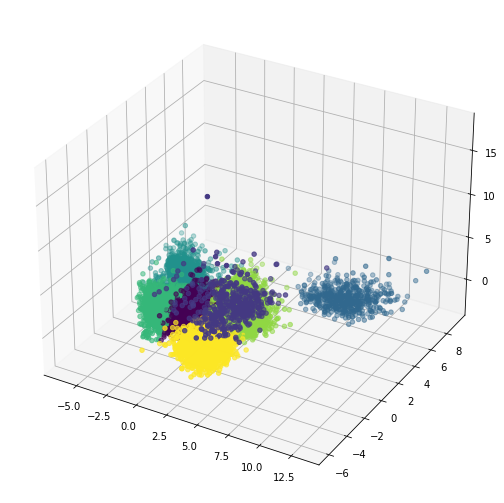

In [18]:
# Plot the projection according to the k-means clusters
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans_labels)
plt.show()

### Cluster Validation 

Several methods: 

* (Normalized) Mutual Information: it measure the agreement of the label assegned by k-means vs true labels;

* Scree Plot: perform k-means with different number of clusters, register the loss. Plot the loss as function of the number of the classes. An elbow in the scree plot should provide useful information about the parameter $k$.

In [19]:
# Compute the normalized mutual information between the predicted and the ground truth classification
normalized_mutual_info_score(kmeans_labels, y.flatten())

0.71378794072991

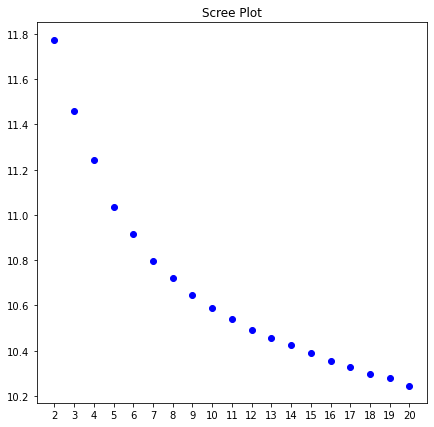

In [20]:
# scree plot
nk_base = np.arange(2,21) # possible values for k in k-means
loss = np.zeros(nk_base.shape[0])
i = 0
for nk in nk_base:
    ll,l_kmeans = k_means(nk, X_scaled, init='++', n_init=20)
    loss[i] = l_kmeans
    i = i + 1
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(nk_base, np.log(loss), c='b')
ax.set_xticks(nk_base)
ax.set_title('Scree Plot')
plt.show()

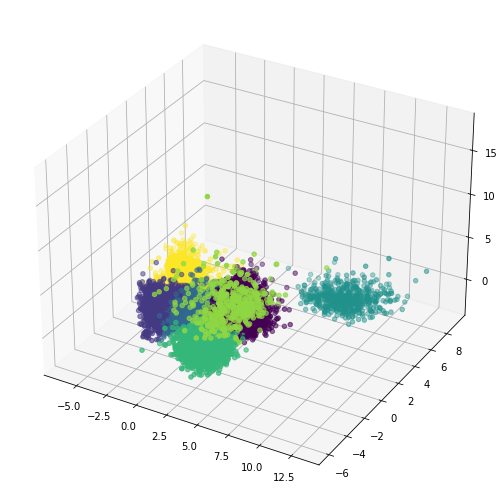

0.7137637558816043

In [24]:
# k is set to the ground truth number of clusters
kmeans = KMeans(n_clusters=7, random_state=0, n_init=20).fit(X_scaled)
# Plot the projection according to the k-means clusters
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans.labels_)
plt.show()
normalized_mutual_info_score(kmeans.labels_, y.flatten())

### Build the scree plot

In order to locate approximately the elbow, we fit the first, let's say 4 points with a line and the last 4 points with a line, then the elbow will be approximately at the intersection. 

In [25]:
# linear fit of first 4 points
reg = LinearRegression().fit(nk_base[:4].reshape(-1, 1), np.log(loss[:4]))
aa = reg.predict(nk_base[:8].reshape(-1, 1))
# linear fit of last 4 points
reg2 = LinearRegression().fit(nk_base[16:20].reshape(-1, 1), np.log(loss[16:20]))
bb = reg2.predict(nk_base.reshape(-1, 1))

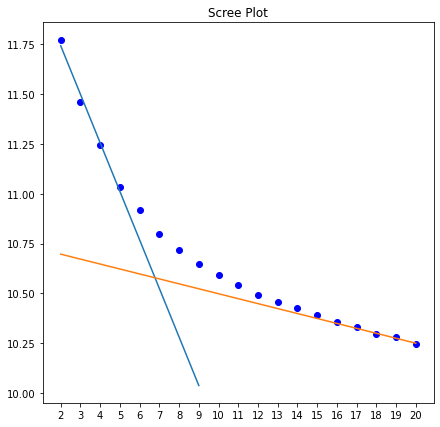

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(nk_base, np.log(loss), c='b')
ax.set_xticks(nk_base)
ax.set_title('Scree Plot')
ax.plot(nk_base[:8], aa[:8])
ax.plot(nk_base, bb)
plt.show()

so the best choice is K=7

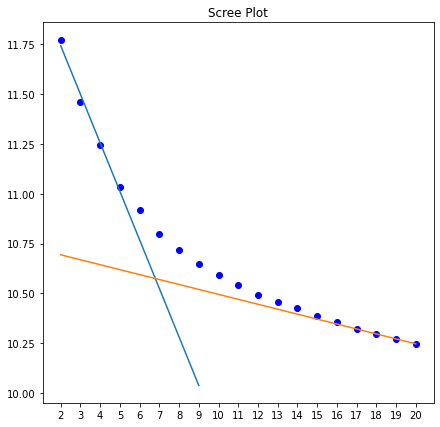

In [27]:
nk_base = np.arange(2,21)
loss = np.zeros(nk_base.shape[0])
i = 0
for nk in nk_base:
    kmeans = KMeans(n_clusters=nk, random_state=0, n_init=20).fit(X_scaled)
    loss[i] = kmeans.inertia_
    i = i+1
reg = LinearRegression().fit(nk_base[:4].reshape(-1, 1),np.log(loss[:4]))
aa = reg.predict(nk_base[:8].reshape(-1, 1))
reg2 = LinearRegression().fit(nk_base[16:20].reshape(-1, 1), np.log(loss[16:20]))
bb = reg2.predict(nk_base.reshape(-1, 1))
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(nk_base,np.log(loss), c='b')
ax.set_xticks(nk_base)
ax.set_title('Scree Plot')
ax.plot(nk_base[:8], aa[:8])
ax.plot(nk_base,bb)
plt.show()

Which is the optimal number of clusters according with the scree plot?

What happens if you don't initialize many times the algorithm?

## Play with other algorithms dimensionality reduction/clustering algorithms.

Try to obtain more information using other algorithms that we have seen during the lectures. Among the suggested algorithms, you can use ISOMAP or t-SNE for dimensional reduction, ward's hierarchical clustering, GMM or DBSCAN for clustering. You don't need to implement these algorithms, use any of the libraries in which them are already implemented (sklearn/scipy). 

Since it's relatively easy, you can try to implement Density Peaks clustering.

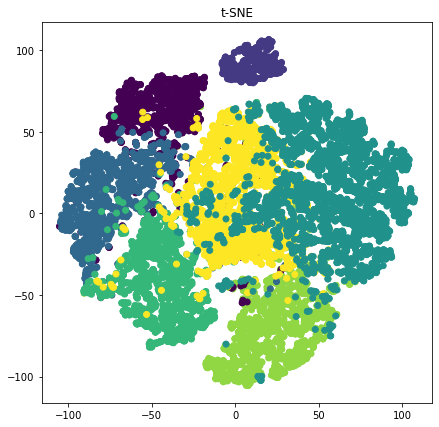

In [28]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15).fit_transform(X_scaled)
fig, ax =plt.subplots(figsize=(7,7))
ax.scatter(X_embedded[:,0],X_embedded[:,1], c=y)
ax.set_title('t-SNE')
plt.show()

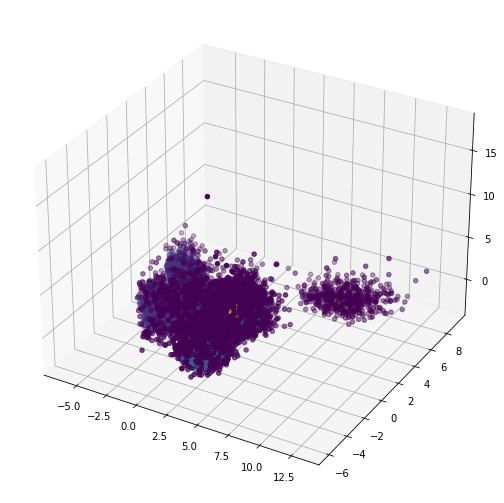

In [29]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=12).fit(X_scaled)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0],projection[:,1], projection[:,2],c=dbscan.labels_)
plt.show()

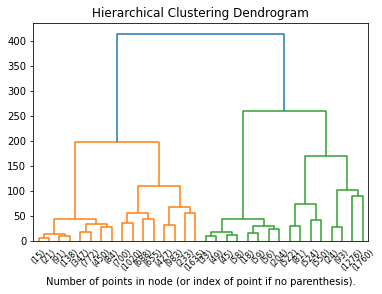

In [30]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_scaled)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

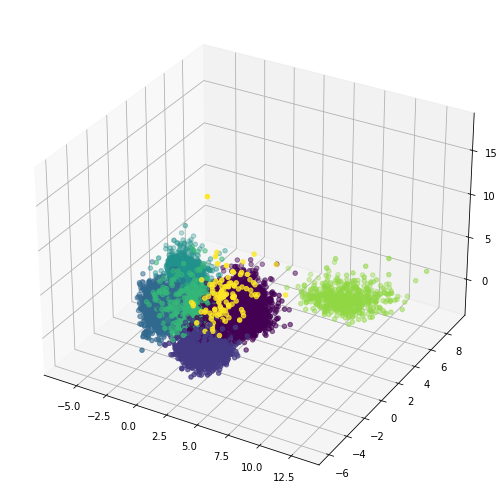

In [31]:
ward = AgglomerativeClustering(n_clusters=7).fit(X_scaled)
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0],projection[:,1], projection[:,2],c=ward.labels_)
plt.show()

In [32]:
print ("kmeans", normalized_mutual_info_score(kmeans_labels, y.flatten()))
print ("dbscan", normalized_mutual_info_score(dbscan.labels_, y.flatten()))
print ("ward's", normalized_mutual_info_score(ward.labels_, y.flatten()))

kmeans 0.71378794072991
dbscan 0.40636265455686627
ward's 0.7325285591840689
